## **Libraries**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from scipy.stats import chi2_contingency

#preprocessing libraries 

from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from imblearn.combine import SMOTEENN
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFromModel
from scipy.stats import randint as sp_randint, uniform as sp_uniform
import lightgbm as lgb

## **Dataset Loading**

In [2]:
train_df=pd.read_csv("/kaggle/input/predict-the-success-of-bank-telemarketing/train.csv")
test_df=pd.read_csv("/kaggle/input/predict-the-success-of-bank-telemarketing/test.csv")
submission_df=pd.read_csv('/kaggle/input/predict-the-success-of-bank-telemarketing/sample_submission.csv')

x=train_df.copy()

## **Exploratory Data Analysis**

### **Examining the Data**

In [3]:
print(x.shape)

print("No of dupliates to remove: ",x.duplicated().sum())
x.drop_duplicates(inplace=True)
x.reset_index(drop=True, inplace=True)
print(x.shape)

(39211, 16)
No of dupliates to remove:  0
(39211, 16)


In [4]:
x.describe()

,age,balance,duration,campaign,pdays,previous
count,39211.000000,39211.000000,39211.000000,39211.000000,39211.000000,39211.000000
mean,42.120247,5441.781719,439.062789,5.108770,72.256051,11.826171
std,12.709352,16365.292065,769.096291,9.890153,160.942593,44.140259
min,18.000000,-8019.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,98.000000,109.000000,1.000000,-1.000000,0.000000
50%,40.000000,549.000000,197.000000,2.000000,-1.000000,0.000000
75%,50.000000,2030.000000,380.000000,4.000000,-1.000000,0.000000
max,95.000000,102127.000000,4918.000000,63.000000,871.000000,275.000000


In [5]:
x.isna().sum() #job, eduation, contact, poutcome has null values

last contact date        0
age                      0
job                    229
marital                  0
education             1467
default                  0
balance                  0
housing                  0
loan                     0
contact              10336
duration                 0
campaign                 0
pdays                    0
previous                 0
poutcome             29451
target                   0
dtype: int64

### **Visualization**

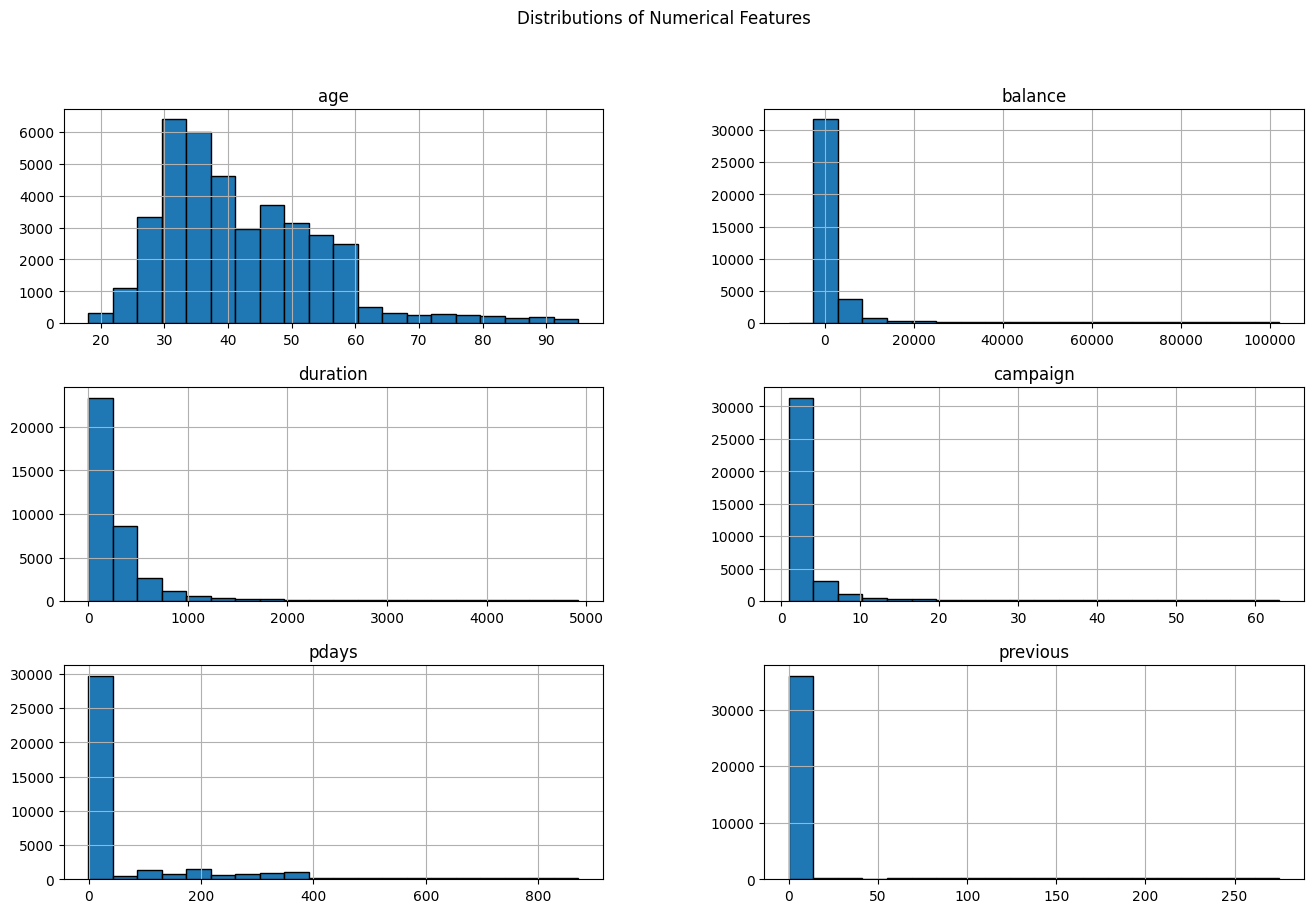

In [6]:
#Visualize distributions

x.hist(bins=20, edgecolor='black',figsize=(16,10))
plt.suptitle('Distributions of Numerical Features')

plt.show()

In [7]:
#Correlation matrix

numerical_features = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']
correlation_matrix = x[numerical_features].corr()
print("Correlation Matrix:")

print(correlation_matrix)

Correlation Matrix:
               age   balance  duration  campaign     pdays  previous
age       1.000000  0.289150  0.255573  0.269439  0.199507  0.277487
balance   0.289150  1.000000  0.669737  0.674339  0.562097  0.716816
duration  0.255573  0.669737  1.000000  0.630944  0.527020  0.683951
campaign  0.269439  0.674339  0.630944  1.000000  0.519469  0.689211
pdays     0.199507  0.562097  0.527020  0.519469  1.000000  0.586175
previous  0.277487  0.716816  0.683951  0.689211  0.586175  1.000000


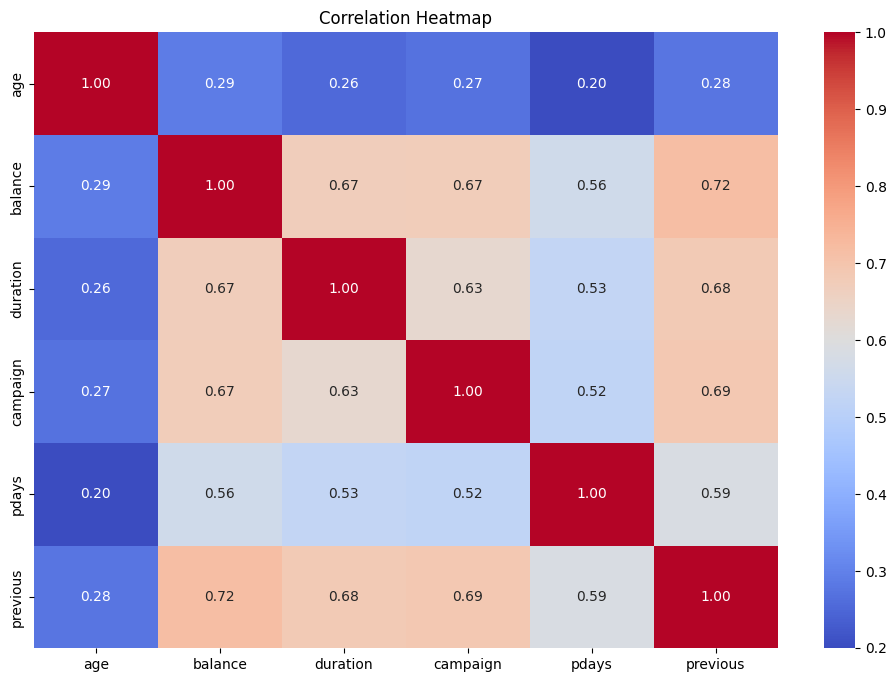

In [8]:
# Heatmap for better visualization

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')

plt.show()

In [9]:
# Pearson correlation between age and balance
corr, _ = pearsonr(x['age'], x['balance'])

print(f'Pearson correlation between Age and Balance: {corr}')

Pearson correlation between Age and Balance: 0.2891499643200483


In [10]:
# Create a contingency table between two categorical variables: education and default
contingency_table = pd.crosstab(x['education'], x['default'])

# Perform chi-square test
chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f'Chi-square test result\nChi2 Statistic: {chi2}, p-value: {p}')

Chi-square test result
Chi2 Statistic: 256.26962401452437, p-value: 2.2478027879533247e-56


## **Data Preprocessing**

In [11]:
# Convert 'last contact date' to datetime and extract features
train_df['last contact date'] = pd.to_datetime(train_df['last contact date'])
train_df['contact_year'] = train_df['last contact date'].dt.year
train_df['contact_month'] = train_df['last contact date'].dt.month
train_df['contact_day'] = train_df['last contact date'].dt.day
train_df['contact_dayofweek'] = train_df['last contact date'].dt.dayofweek

test_df['last contact date'] = pd.to_datetime(test_df['last contact date'])
test_df['contact_year'] = test_df['last contact date'].dt.year
test_df['contact_month'] = test_df['last contact date'].dt.month
test_df['contact_day'] = test_df['last contact date'].dt.day
test_df['contact_dayofweek'] = test_df['last contact date'].dt.dayofweek

# Drop the original 'last contact date' column
train_df.drop('last contact date', axis=1, inplace=True)
test_df.drop('last contact date', axis=1, inplace=True)

# Handle missing values in categorical columns
for col in ['job', 'education', 'contact', 'poutcome']:
    train_df[col] = train_df[col].fillna('Unknown')
    test_df[col] = test_df[col].fillna('Unknown')

# Encode categorical variables using one-hot encoding
train_df_encoded = pd.get_dummies(train_df, columns=['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome'])
test_df_encoded = pd.get_dummies(test_df, columns=['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome'])

# Align test_df_encoded to train_df_encoded
test_df_encoded = test_df_encoded.reindex(columns=train_df_encoded.columns, fill_value=0)

# Separate features and target variable
X = train_df_encoded.drop('target', axis=1)
y = train_df_encoded['target'].apply(lambda x: 1 if x == 'yes' else 0)
X_test_final = test_df_encoded.drop('target', axis=1)

# Scale the numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test_final)

# Address class imbalance using SMOTE-ENN
smote_enn = SMOTEENN(random_state=42)
X_resampled, y_resampled = smote_enn.fit_resample(X_scaled, y)

# Split the data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)




## **Dimensionality Reduction**

In [12]:
# Dimensionality Reduction using PCA
pca = PCA(n_components=0.95)  # Retain 95% of variance
X_train_pca = pca.fit_transform(X_train)
X_valid_pca = pca.transform(X_valid)
X_test_pca = pca.transform(X_test_scaled)

## **Feature Selection**

In [13]:
# Feature Selection using ExtraTreesClassifier
from sklearn.ensemble import ExtraTreesClassifier

feature_selector = SelectFromModel(ExtraTreesClassifier(n_estimators=100, random_state=42))
X_train_selected = feature_selector.fit_transform(X_train, y_train)
X_valid_selected = feature_selector.transform(X_valid)
X_test_selected = feature_selector.transform(X_test_scaled)

## **Model 1: Random Forest**

In [14]:
# Define hyperparameter distributions for Random Forest
param_dist_rf = {
    'n_estimators': sp_randint(100, 300),
    'max_depth': sp_randint(10, 30),
    'min_samples_split': sp_randint(2, 10),
    'min_samples_leaf': sp_randint(1, 4)
}

# Initialize Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Hyperparameter tuning for Random Forest
rf_search = RandomizedSearchCV(rf_model, param_dist_rf, n_iter=20, cv=StratifiedKFold(3), scoring='f1_macro', n_jobs=-1, random_state=42)
rf_search.fit(X_train_selected, y_train)

# Evaluate Random Forest model
rf_best_model = rf_search.best_estimator_
rf_preds = rf_best_model.predict(X_valid_selected)
rf_f1 = f1_score(y_valid, rf_preds, average='macro')
print(f"Random Forest F1 Score: {rf_f1}")

Random Forest F1 Score: 0.9623641687640845


## **Model 2 : Logistic Regression**

In [15]:
# Define hyperparameter distributions for Logistic Regression
param_dist_log_reg = {
    'C': sp_uniform(0.01, 10),
    'solver': ['liblinear', 'saga'],
    'max_iter': sp_randint(100, 300)
}

# Initialize Logistic Regression model
log_reg_model = LogisticRegression(random_state=42)

# Hyperparameter tuning for Logistic Regression
log_reg_search = RandomizedSearchCV(log_reg_model, param_dist_log_reg, n_iter=20, cv=StratifiedKFold(3), scoring='f1_macro', n_jobs=-1, random_state=42)
log_reg_search.fit(X_train_selected, y_train)

# Evaluate Logistic Regression model
log_reg_best_model = log_reg_search.best_estimator_
log_reg_preds = log_reg_best_model.predict(X_valid_selected)
log_reg_f1 = f1_score(y_valid, log_reg_preds, average='macro')
print(f"Logistic Regression F1 Score: {log_reg_f1}")

Logistic Regression F1 Score: 0.8737245070208102


## **Model 3: LightGBM**

In [16]:
#Define hyperparameter distributions for LightGBM
param_dist_lgb = {
    'n_estimators': sp_randint(100, 200),
    'max_depth': sp_randint(5, 15),
    'learning_rate': sp_uniform(0.01, 0.1)
}

# Initialize LightGBM model
lgb_model = lgb.LGBMClassifier(random_state=42)

# Hyperparameter tuning for LightGBM
lgb_search = RandomizedSearchCV(lgb_model, param_dist_lgb, n_iter=20, cv=StratifiedKFold(3), scoring='f1_macro', n_jobs=-1, random_state=42)
lgb_search.fit(X_train_selected, y_train)

# Evaluate LightGBM model
lgb_best_model = lgb_search.best_estimator_
lgb_preds = lgb_best_model.predict(X_valid_selected)
lgb_f1 = f1_score(y_valid, lgb_preds, average='macro')
print(f"LightGBM F1 Score: {lgb_f1}")

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 16484, number of negative: 13148
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010271 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3059
[LightGBM] [Info] Number of data points in the train set: 29632, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.556290 -> initscore=0.226121
[LightGBM] [Info] Start training from score 0.226121
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_

## **Model Selection**

In [17]:
best_model_name = None
best_f1_score = 0
final_best_model = None

for model, f1 in zip(['Random Forest', 'Logistic Regression', 'LightGBM'], [rf_f1, log_reg_f1, lgb_f1]):
    if f1 > best_f1_score:
        best_f1_score = f1
        best_model_name = model
        if model == 'Random Forest':
            final_best_model = rf_best_model
        elif model == 'Logistic Regression':
            final_best_model = log_reg_best_model
        elif model == 'LightGBM':
            final_best_model = lgb_best_model

print(f"\nBest model: {best_model_name} with F1 Score: {best_f1_score}")


Best model: LightGBM with F1 Score: 0.9662800504372184


## **Submission**

In [18]:
# Predict on the test set with the best model
test_predictions = final_best_model.predict(X_test_selected)
test_predictions_labels = ['yes' if pred == 1 else 'no' for pred in test_predictions]

# Create submission file
submission_df['target'] = test_predictions_labels
submission_df.to_csv('submission.csv', index=False)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
